In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


In [2]:
original_img1 = cv2.imread('pahlavi.jpg') #query
original_img2 = cv2.imread('coins.jpg') #train

result = original_img2.copy()
img1 = cv2.cvtColor(original_img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(original_img2, cv2.COLOR_BGR2GRAY)

# Initiate SIFT detector
sift = cv2.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)
        
MIN_MATCH_COUNT = 10


if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    result = cv2.polylines(result,[np.int32(dst)],True,(0,255,0),3, cv2.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

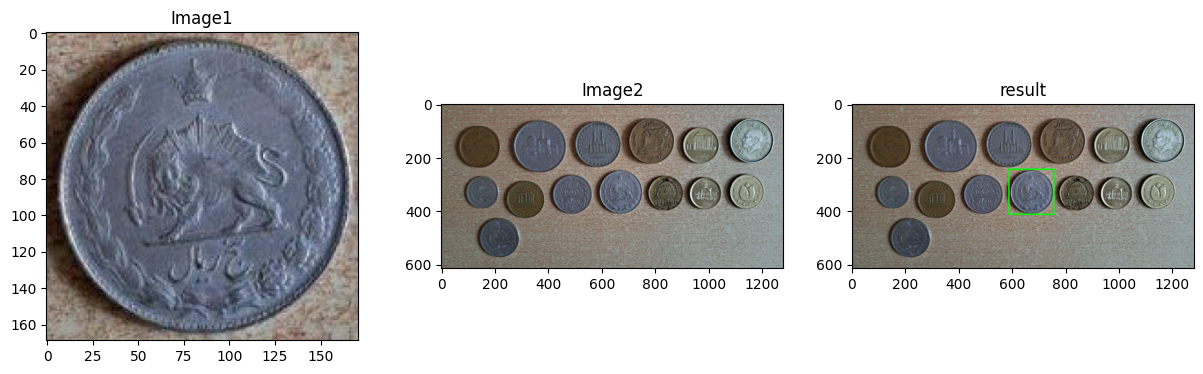

In [3]:
plt.figure(figsize=[15,4])
plt.subplot(131),plt.imshow(original_img1[...,::-1]),plt.title('Image1');
plt.subplot(132),plt.imshow(original_img2[...,::-1]),plt.title('Image2');
plt.subplot(133),plt.imshow(result[...,::-1]),plt.title('result');